In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split

In [2]:
# Load the training set.
train_df = pd.read_csv("train.csv")

In [3]:
# Load the test set.
test_df = pd.read_csv("test.csv")


Sales Price Statistical Summary:
 count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

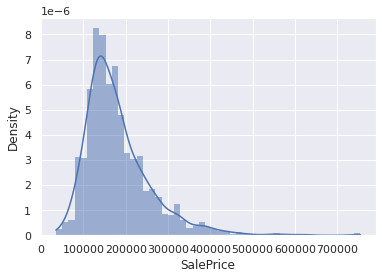

In [4]:
# Sales Price Analysis in the training set
print('\nSales Price Statistical Summary:\n',train_df['SalePrice'].describe())
# Histogram for sales price
sns.histplot(train_df['SalePrice'], kde=True, stat='density', linewidth=0)

Text(0.5, 1.04, 'Correlation coefficient heatmap')

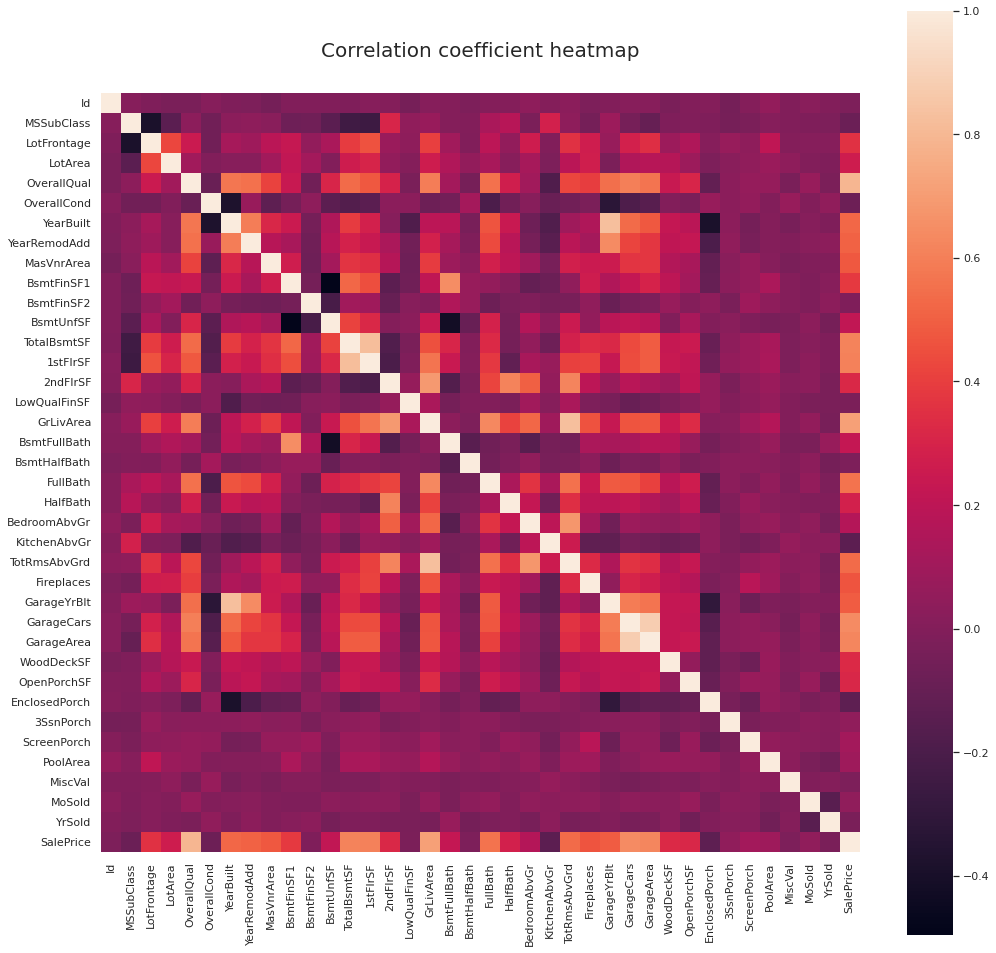

In [5]:
# Generate heatmap to see the correlation between features
correlation_map=train_df.corr()
plt.subplots(figsize=(17,17))
sns.heatmap(correlation_map, vmax=1, square=True)
plt.title('Correlation coefficient heatmap',fontsize=20,y=1.04)

In [6]:
# # order the variable in ascending order by correlation to see the features in the importance order
# correlation_train=train_df.corr()  
# corr_dict=correlation_train['SalePrice'].sort_values(ascending=False).to_dict()
# important_columns=[]
# for key,value in corr_dict.items():
#     if ((value>0.1) & (value<0.9)) or (value<=-0.1):
#         important_columns.append(key)
# important_columns

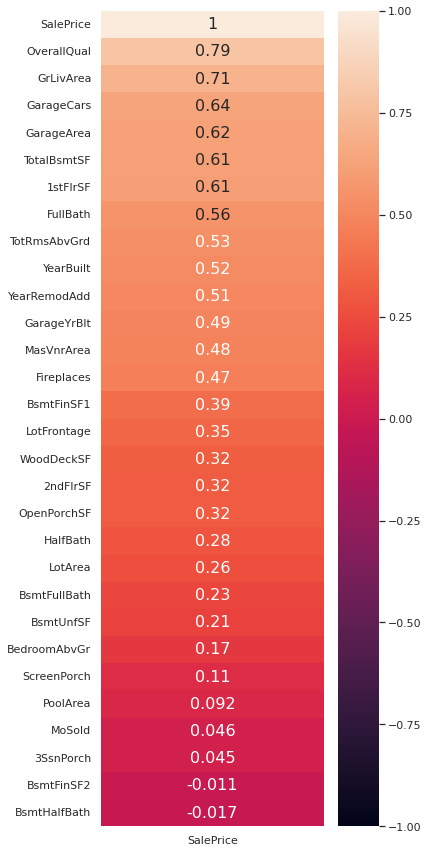

In [7]:
# Arrange the features in the importance order (the higher is the more important)
plt.figure(figsize=(5,15))
sns.heatmap(correlation_map[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, annot=True)
sns.set(font_scale=2)

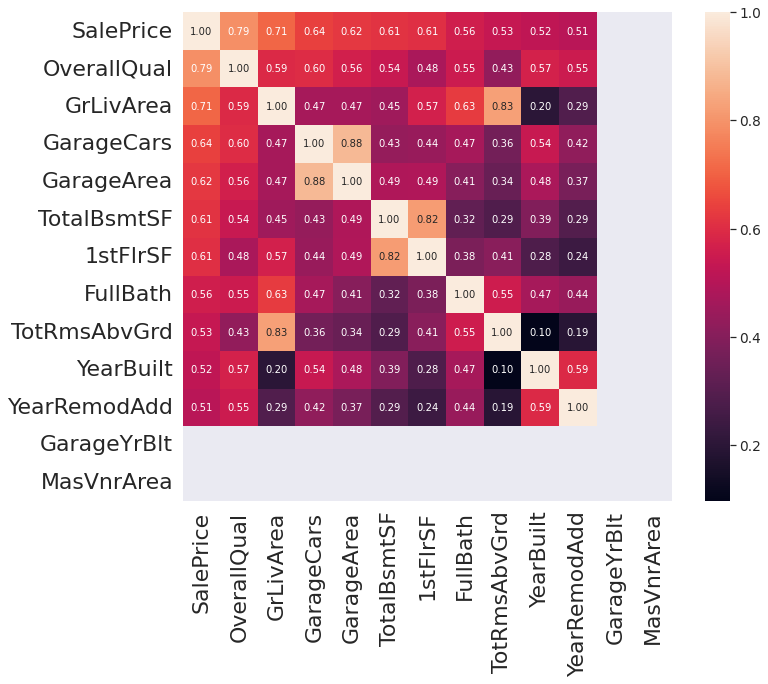

In [8]:
# saleprice correlation matrix
k = 13 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = correlation_map.nlargest(k, 'SalePrice')['SalePrice'].index
sns.set(font_scale=1.25)
sns.heatmap(np.corrcoef(train_df[cols].values.T), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
# Picked 9 most important features from the heat map
new_train = train_df[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd',
                      'GarageYrBlt','MasVnrArea', 'SalePrice']]
new_test = test_df[['OverallQual','GrLivArea','GarageCars','TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd',
                      'GarageYrBlt','MasVnrArea']]
new_train.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,SalePrice
0,7,1710,2,856,2,2003,2003,2003.0,196.0,208500
1,6,1262,2,1262,2,1976,1976,1976.0,0.0,181500
2,7,1786,2,920,2,2001,2002,2001.0,162.0,223500
3,7,1717,3,756,1,1915,1970,1998.0,0.0,140000
4,8,2198,3,1145,2,2000,2000,2000.0,350.0,250000


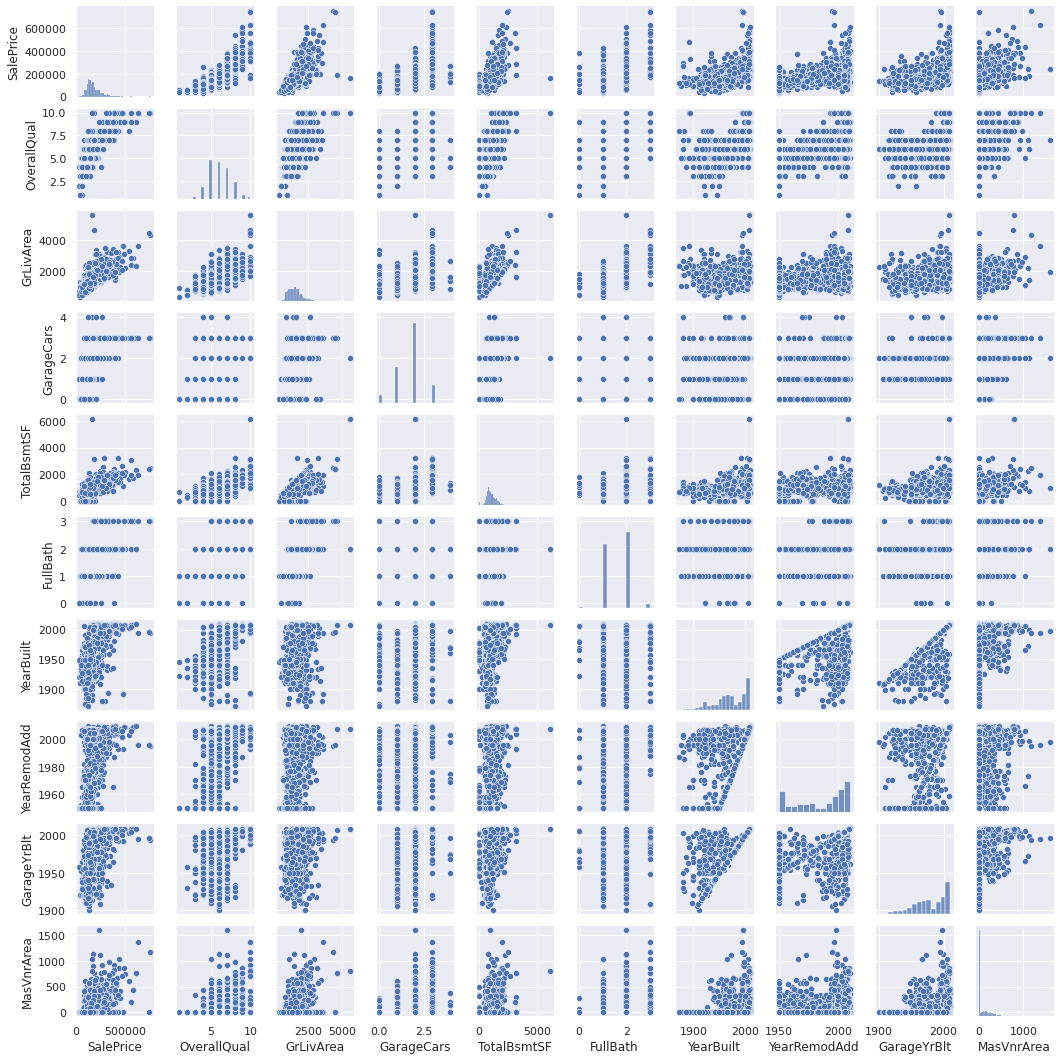

In [10]:
# Plot scatterplots for the features selected to see the graphical relationship between the features
sns.set()
column = ['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd',
                      'GarageYrBlt','MasVnrArea']
sns.pairplot(new_train[column], height = 1.5)
plt.show();

In [11]:
# Count how many 'NA' data points in 'GarageYrBlt' feature 
sum(new_train['GarageYrBlt'].isnull())

81

In [12]:
# Get mean value of GarageYrBlt 
avg_GarageYrBlt = np.mean(new_train['GarageYrBlt'])

In [13]:
# Replace 'NA' data points with mean of whole data points in 'GarageYrBlt' feature
new_train['GarageYrBlt'] = new_train['GarageYrBlt'].fillna(avg_GarageYrBlt)

/tmp/ipykernel_109/39600473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['GarageYrBlt'] = new_train['GarageYrBlt'].fillna(avg_GarageYrBlt)


In [14]:
# Count how many 'NA' data points in 'MasVnrArea' feature 
sum(new_train['MasVnrArea'].isnull())

8

In [15]:
# Get mean value of MasVnrArea
avg_MasVnrArea = np.mean(new_train['MasVnrArea'])

In [16]:
# Replace 'NA' data points with mean of whole data points in 'MasVnrArea' feature
new_train['MasVnrArea'] = new_train['MasVnrArea'].fillna(avg_MasVnrArea)

/tmp/ipykernel_109/3962251613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train['MasVnrArea'] = new_train['MasVnrArea'].fillna(avg_MasVnrArea)


In [17]:
# Detect any outlier : Quantil based flooring and capping method
traindata_nosalesprice = new_train.drop(['SalePrice'],axis='columns')
def detect_outliers_zscore(data):
    outliers = []
    thres = 2
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
outliers_overallqual = detect_outliers_zscore(traindata_nosalesprice['OverallQual'])
outliers_GrLivArea = detect_outliers_zscore(traindata_nosalesprice['GrLivArea'])
outliers_GarageCars = detect_outliers_zscore(traindata_nosalesprice['GarageCars'])
outliers_TotalBsmtSF = detect_outliers_zscore(traindata_nosalesprice['TotalBsmtSF'])
outliers_FullBath = detect_outliers_zscore(traindata_nosalesprice['FullBath'])
outliers_YearBuilt = detect_outliers_zscore(traindata_nosalesprice['YearBuilt'])
outliers_YearRemodAdd = detect_outliers_zscore(traindata_nosalesprice['YearRemodAdd'])
outliers_GarageYrBlt = detect_outliers_zscore(traindata_nosalesprice['GarageYrBlt'])
outliers_MasVnrArea = detect_outliers_zscore(traindata_nosalesprice['MasVnrArea'])

In [18]:
# Replace the outliers : Quantil based flooring and capping method
def replace_outlier(feature):
# Computing 10th, 90th percentiles and replacing the outliers
    tenth_percentile = np.percentile(traindata_nosalesprice[feature], 10)
    ninetieth_percentile = np.percentile(traindata_nosalesprice[feature], 90)
    print(tenth_percentile,ninetieth_percentile)
# print(tenth_percentile, ninetieth_percentile)
    b = np.where(traindata_nosalesprice[feature]<tenth_percentile, tenth_percentile, traindata_nosalesprice[feature])
    b = np.where(b>ninetieth_percentile, ninetieth_percentile, b)
    print(feature,b)
# print("Overallqual:", traindata_nosalesprice['OverallQual'])
    dic = {'A': b}
    df_replace = pd.DataFrame(dic)
    traindata_nosalesprice[feature] = df_replace['A'].values
    
# print("Overallqual:", traindata_nosalesprice['OverallQual'])
    return traindata_nosalesprice
replace_outlier('OverallQual') 
replace_outlier('GrLivArea')  
replace_outlier('GarageCars') 
replace_outlier('TotalBsmtSF') 
replace_outlier('FullBath')
replace_outlier('YearBuilt') 
replace_outlier('YearRemodAdd')
replace_outlier('GarageYrBlt') 
replace_outlier('MasVnrArea')


5.0 8.0
OverallQual [7. 6. 7. ... 7. 5. 5.]
912.0 2158.3
GrLivArea [1710.  1262.  1786.  ... 2158.3 1078.  1256. ]
1.0 3.0
GarageCars [2. 2. 2. ... 1. 1. 1.]
636.9 1602.2000000000003
TotalBsmtSF [ 856. 1262.  920. ... 1152. 1078. 1256.]
1.0 2.0
FullBath [2. 2. 2. ... 2. 1. 1.]
1924.9 2006.0
YearBuilt [2003. 1976. 2001. ... 1941. 1950. 1965.]
1950.0 2006.0
YearRemodAdd [2003. 1976. 2002. ... 2006. 1996. 1965.]
1948.0 2006.0
GarageYrBlt [2003. 1976. 2001. ... 1948. 1950. 1965.]
0.0 335.0
MasVnrArea [196.   0. 162. ...   0.   0.   0.]


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea
0,7.0,1710.0,2.0,856.0,2.0,2003.0,2003.0,2003.0,196.0
1,6.0,1262.0,2.0,1262.0,2.0,1976.0,1976.0,1976.0,0.0
2,7.0,1786.0,2.0,920.0,2.0,2001.0,2002.0,2001.0,162.0
3,7.0,1717.0,3.0,756.0,1.0,1924.9,1970.0,1998.0,0.0
4,8.0,2158.3,3.0,1145.0,2.0,2000.0,2000.0,2000.0,335.0
...,...,...,...,...,...,...,...,...,...
1455,6.0,1647.0,2.0,953.0,2.0,1999.0,2000.0,1999.0,0.0
1456,6.0,2073.0,2.0,1542.0,2.0,1978.0,1988.0,1978.0,119.0
1457,7.0,2158.3,1.0,1152.0,2.0,1941.0,2006.0,1948.0,0.0
1458,5.0,1078.0,1.0,1078.0,1.0,1950.0,1996.0,1950.0,0.0


In [19]:
# MasVnrArea, case shows outlier = 335, 335 = 90 percentile value, so its okay
detect_outliers_zscore(traindata_nosalesprice['MasVnrArea'])

[335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 333.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 328.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 328.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,
 335.0,


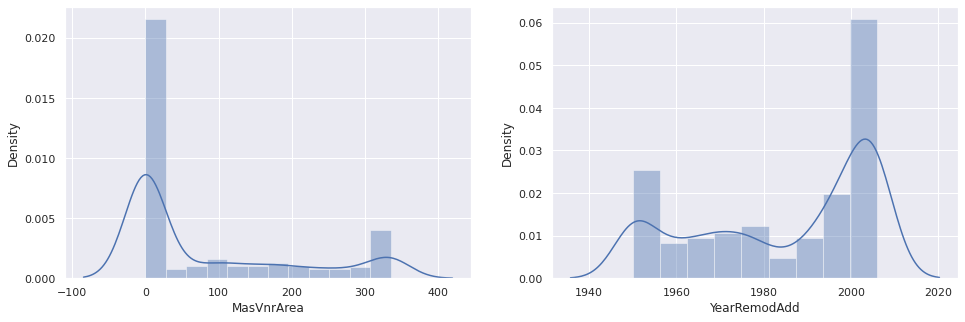

In [20]:
# Visualize each feature to see any outliers after Quantil based flooring and capping method
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(traindata_nosalesprice['MasVnrArea'])
plt.subplot(1,2,2)
sns.distplot(traindata_nosalesprice['YearRemodAdd'])
plt.show()

In [21]:
# # this method assumes our data distribution is in Normal distribution
# # if the model performance is low, then we can refer this point
# # 'OverallQual','GrLivArea','GarageCars','TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd',
# #                       'GarageYrBlt','MasVnrArea', 'SalePrice'
# import warnings
# warnings.filterwarnings('ignore')
# plt.figure(figsize=(16,5))
# plt.subplot(1,2,1)
# sns.distplot(new_train['YearRemodAdd'])
# plt.subplot(1,2,2)
# sns.distplot(new_train['GarageYrBlt'])
# plt.show()

In [22]:
# #  Finding the Boundary Values
# a = new_train['OverallQual'].mean() + 3*new_train['OverallQual'].std()
# b = new_train['OverallQual'].mean() - 3*new_train['OverallQual'].std()
# print("Highest allowed",a)
# print("Lowest allowed",b)

In [23]:
# # Finding the Outliers
# new_train[(new_train['OverallQual'] > a) | (new_train['OverallQual'] < b)]

In [24]:
# # Trimming of Outliers
# new_df = new_train[(new_train['OverallQual'] < a) & (new_train['OverallQual'] > b)]

In [25]:
# # Capping on Outliers
# upper_limit = new_train['OverallQual'].mean() + 3*new_train['OverallQual'].std()
# lower_limit = new_train['OverallQual'].mean() - 3*new_train['OverallQual'].std()

In [26]:
# # Now, apply the Capping
# new_train['OverallQual'] = np.where(
#     new_train['OverallQual']>upper_limit,
#     upper_limit,
#     np.where(
#         new_train['OverallQual']<lower_limit,
#         lower_limit,
#         new_train['OverallQual']
#     )
# )

In [27]:
# # test outlier
# new_train[(new_train['OverallQual'] > a) | (new_train['OverallQual'] < b)]

In [28]:
# https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/

In [29]:
# def z_score_method(feature):
#     #  Finding the Boundary Values
#     a = new_train[feature].mean() + 3*new_train[feature].std()
#     b = new_train[feature].mean() - 3*new_train[feature].std()
#     print("Highest allowed",a)
#     print("Lowest allowed",b)
    
#     # Finding the Outliers
#     new_train[(new_train[feature] > a) | (new_train[feature] < b)]
#     # Trimming of Outliers
#     new_df = new_train[(new_train[feature] < a) & (new_train[feature] > b)]
#     # Capping on Outliers
#     upper_limit = new_train[feature].mean() + 3*new_train[feature].std()
#     lower_limit = new_train[feature].mean() - 3*new_train[feature].std()
#     # Now, apply the Capping
#     new_train[feature] = np.where(
#     new_train[feature]>upper_limit,
#     upper_limit,
#     np.where(
#         new_train[feature]<lower_limit,
#         lower_limit,
#         new_train[feature]
#     )
#     )
#     # Now see the statistics using “Describe” Function
# #     new_train[feature].describe()
#     return new_df

In [32]:
# without Sales Price but cleaned data
traindata_nosalesprice

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea
0,7.0,1710.0,2.0,856.0,2.0,2003.0,2003.0,2003.0,196.0
1,6.0,1262.0,2.0,1262.0,2.0,1976.0,1976.0,1976.0,0.0
2,7.0,1786.0,2.0,920.0,2.0,2001.0,2002.0,2001.0,162.0
3,7.0,1717.0,3.0,756.0,1.0,1924.9,1970.0,1998.0,0.0
4,8.0,2158.3,3.0,1145.0,2.0,2000.0,2000.0,2000.0,335.0
...,...,...,...,...,...,...,...,...,...
1455,6.0,1647.0,2.0,953.0,2.0,1999.0,2000.0,1999.0,0.0
1456,6.0,2073.0,2.0,1542.0,2.0,1978.0,1988.0,1978.0,119.0
1457,7.0,2158.3,1.0,1152.0,2.0,1941.0,2006.0,1948.0,0.0
1458,5.0,1078.0,1.0,1078.0,1.0,1950.0,1996.0,1950.0,0.0


In [34]:
# with sales price but not-cleaned data
new_train['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [ ]:
# combine those two
# -> you will have a complete data set. Training set

In [35]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
